In [26]:
import prophet
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
# Reading data
d = pd.read_csv("Revenue_Главная_web_9-19_2024_01_15 (2).csv")
d.head()

,utc_event_date,revenue_main
0,01/01/21,0.0
1,02/01/21,0.0
2,03/01/21,0.0
3,04/01/21,0.0
4,05/01/21,0.0


In [28]:
# Removing no-data period
d = d[d['revenue_main'] != 0]
d.head()

,utc_event_date,revenue_main
67,09/03/21,1.440000e+02
68,10/03/21,2.858725e+06
69,11/03/21,5.511104e+06
70,12/03/21,5.927380e+06
71,13/03/21,5.042469e+06


In [29]:
# Converting to datetime and renaming for Prophet

d["utc_event_date"] = pd.to_datetime(d["utc_event_date"], dayfirst = True)
d = d.rename(columns={"revenue_main": "y", "utc_event_date": "ds"})
d

/var/folders/23/sf6t2ln1289d0spv6qp4gvbw0000gn/T/ipykernel_27375/2162166473.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d["utc_event_date"] = pd.to_datetime(d["utc_event_date"], dayfirst = True)


,ds,y
67,2021-03-09,1.440000e+02
68,2021-03-10,2.858725e+06
69,2021-03-11,5.511104e+06
70,2021-03-12,5.927380e+06
71,2021-03-13,5.042469e+06
...,...,...
1074,2024-01-09,4.052303e+07
1075,2024-01-10,4.055967e+07
1076,2024-01-11,4.001305e+07
1077,2024-01-12,4.120578e+07


In [30]:
# Setting holidays 

black_fridays = pd.DataFrame({
  'holiday': 'black_friday',
  'ds': pd.to_datetime(['2022-11-26', '2022-11-25', '2023-11-24',]),
  'lower_window': -14,
  'upper_window': 14,
})
new_years = pd.DataFrame({
  'holiday': 'new_year',
  'ds': pd.to_datetime(['2021-12-31', '2022-12-31', '2023-12-31']),
  'lower_window': -2,
  'upper_window': 7,
})
febs_23 = pd.DataFrame({
  'holiday': '23_feb',
  'ds': pd.to_datetime(['2021-02-23', '2022-02-23', '2023-02-23']),
  'lower_window': -4,
  'upper_window': 3,
})

mays_1 = pd.DataFrame({
  'holiday': '1_may',
  'ds': pd.to_datetime(['2021-05-01', '2022-05-01', '2023-05-01']),
  'lower_window': -2,
  'upper_window': 2,
})


holidays = pd.concat((black_fridays, new_years, febs_23, mays_1))
holidays

,holiday,ds,lower_window,upper_window
0,black_friday,2022-11-26,-14,14
1,black_friday,2022-11-25,-14,14
2,black_friday,2023-11-24,-14,14
0,new_year,2021-12-31,-2,7
1,new_year,2022-12-31,-2,7
2,new_year,2023-12-31,-2,7
0,23_feb,2021-02-23,-4,3
1,23_feb,2022-02-23,-4,3
2,23_feb,2023-02-23,-4,3
0,1_may,2021-05-01,-2,2


In [31]:
# Setting Baseline Prophet model
model = Prophet(yearly_seasonality=7, 
            weekly_seasonality=10, 
            holidays=holidays, 
            growth = "linear", 
            holidays_prior_scale = 10,
            n_changepoints = 20,)
model.fit(d)

12:28:52 - cmdstanpy - INFO - Chain [1] start processing
12:28:52 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
# Creating Future Dataset for Forecasting 
future = model.make_future_dataframe(periods=50)
future.tail()

,ds
1057,2024-02-28
1058,2024-02-29
1059,2024-03-01
1060,2024-03-02
1061,2024-03-03


In [33]:
forecast = model.predict(future)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


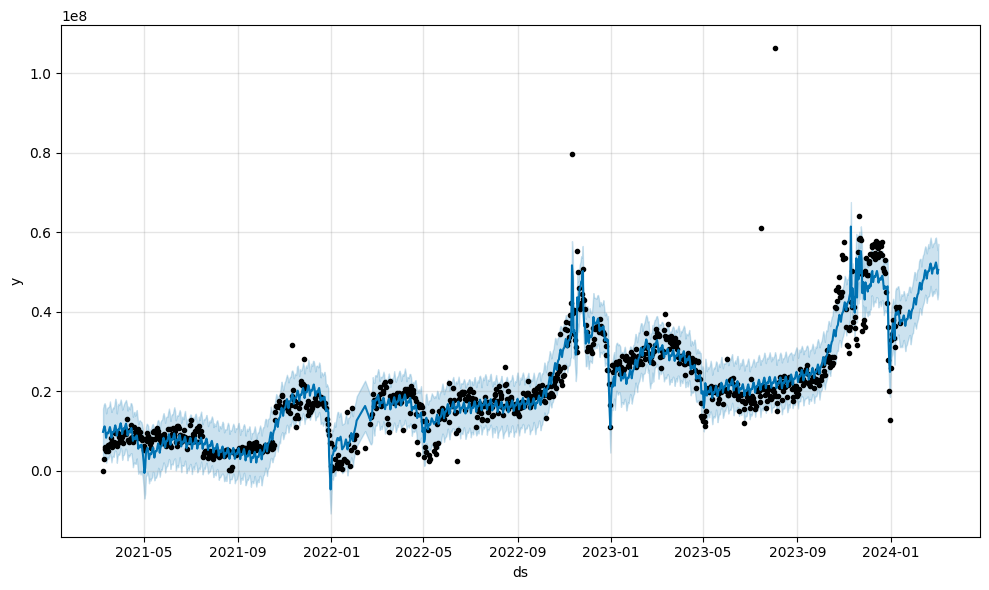

In [34]:
predict_plot = model.plot(forecast)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will

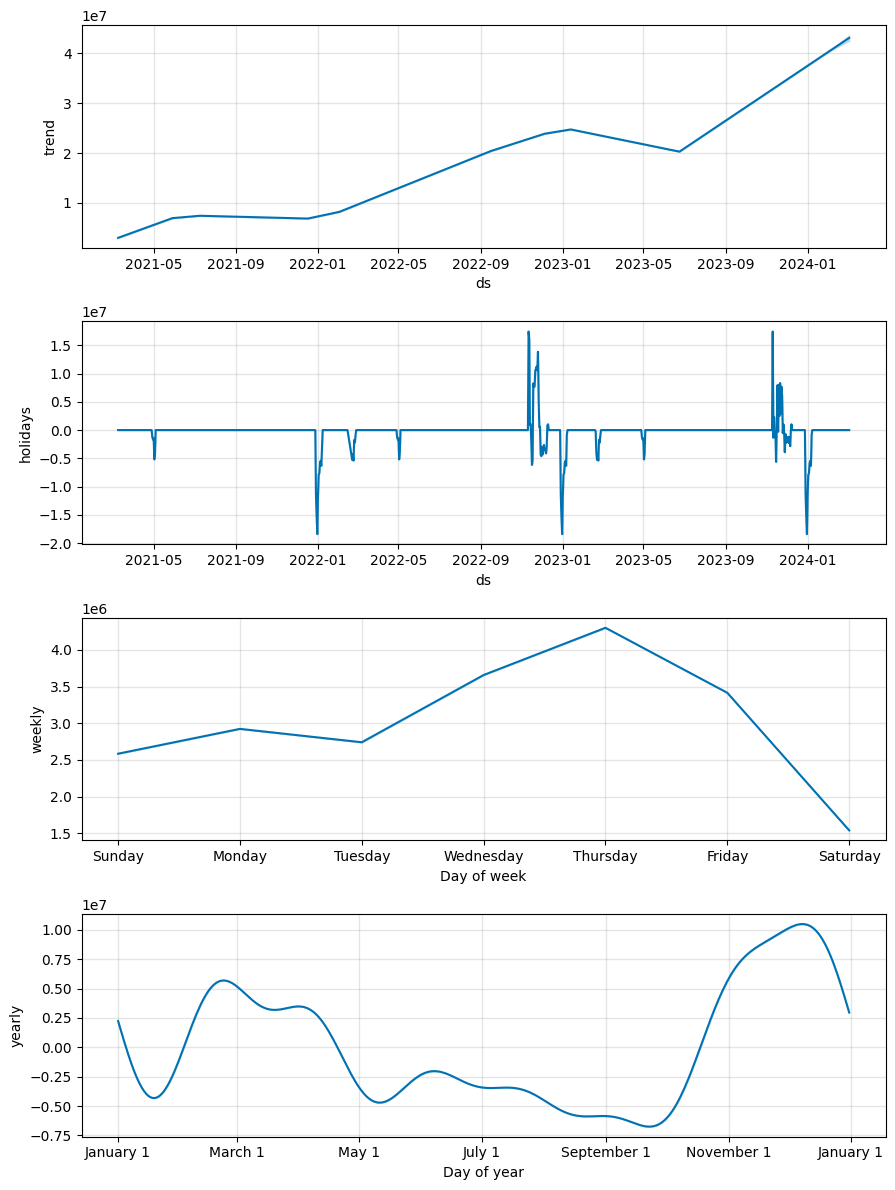

In [35]:
components_plot = model.plot_components(forecast)

In [47]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,1_may,1_may_lower,1_may_upper,23_feb,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-03-09,3.015207e+06,3.211080e+06,1.561919e+07,3.015207e+06,3.015207e+06,0.0,0.0,0.0,0.0,...,2.741309e+06,2.741309e+06,2.741309e+06,3.995216e+06,3.995216e+06,3.995216e+06,0.0,0.0,0.0,9.751733e+06
1,2021-03-10,3.063969e+06,4.302973e+06,1.658784e+07,3.063969e+06,3.063969e+06,0.0,0.0,0.0,0.0,...,3.657369e+06,3.657369e+06,3.657369e+06,3.857932e+06,3.857932e+06,3.857932e+06,0.0,0.0,0.0,1.057927e+07
2,2021-03-11,3.112730e+06,4.466047e+06,1.698031e+07,3.112730e+06,3.112730e+06,0.0,0.0,0.0,0.0,...,4.300748e+06,4.300748e+06,4.300748e+06,3.730838e+06,3.730838e+06,3.730838e+06,0.0,0.0,0.0,1.114432e+07
3,2021-03-12,3.161491e+06,3.676369e+06,1.644933e+07,3.161491e+06,3.161491e+06,0.0,0.0,0.0,0.0,...,3.415362e+06,3.415362e+06,3.415362e+06,3.615402e+06,3.615402e+06,3.615402e+06,0.0,0.0,0.0,1.019226e+07
4,2021-03-13,3.210252e+06,1.989782e+06,1.440906e+07,3.210252e+06,3.210252e+06,0.0,0.0,0.0,0.0,...,1.541466e+06,1.541466e+06,1.541466e+06,3.512807e+06,3.512807e+06,3.512807e+06,0.0,0.0,0.0,8.264525e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057,2024-02-28,4.272438e+07,4.562288e+07,5.845450e+07,4.224438e+07,4.317124e+07,0.0,0.0,0.0,0.0,...,3.657369e+06,3.657369e+06,3.657369e+06,5.417841e+06,5.417841e+06,5.417841e+06,0.0,0.0,0.0,5.179959e+07
1058,2024-02-29,4.281447e+07,4.579295e+07,5.869830e+07,4.231389e+07,4.327449e+07,0.0,0.0,0.0,0.0,...,4.300748e+06,4.300748e+06,4.300748e+06,5.302049e+06,5.302049e+06,5.302049e+06,0.0,0.0,0.0,5.241726e+07
1059,2024-03-01,4.290455e+07,4.471489e+07,5.717509e+07,4.238271e+07,4.339645e+07,0.0,0.0,0.0,0.0,...,3.415362e+06,3.415362e+06,3.415362e+06,5.172126e+06,5.172126e+06,5.172126e+06,0.0,0.0,0.0,5.149204e+07
1060,2024-03-02,4.299463e+07,4.310358e+07,5.553848e+07,4.245044e+07,4.350424e+07,0.0,0.0,0.0,0.0,...,1.541466e+06,1.541466e+06,1.541466e+06,5.030926e+06,5.030926e+06,5.030926e+06,0.0,0.0,0.0,4.956702e+07


In [48]:
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]

,ds,yhat,yhat_lower,yhat_upper
0,2021-03-09,9.751733e+06,3.211080e+06,1.561919e+07
1,2021-03-10,1.057927e+07,4.302973e+06,1.658784e+07
2,2021-03-11,1.114432e+07,4.466047e+06,1.698031e+07
3,2021-03-12,1.019226e+07,3.676369e+06,1.644933e+07
4,2021-03-13,8.264525e+06,1.989782e+06,1.440906e+07
...,...,...,...,...
1057,2024-02-28,5.179959e+07,4.562288e+07,5.845450e+07
1058,2024-02-29,5.241726e+07,4.579295e+07,5.869830e+07
1059,2024-03-01,5.149204e+07,4.471489e+07,5.717509e+07
1060,2024-03-02,4.956702e+07,4.310358e+07,5.553848e+07


In [45]:
d

,ds,y
67,2021-03-09,1.440000e+02
68,2021-03-10,2.858725e+06
69,2021-03-11,5.511104e+06
70,2021-03-12,5.927380e+06
71,2021-03-13,5.042469e+06
...,...,...
1074,2024-01-09,4.052303e+07
1075,2024-01-10,4.055967e+07
1076,2024-01-11,4.001305e+07
1077,2024-01-12,4.120578e+07


In [50]:
df = pd.merge(d, forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]], how = "right", on = "ds")

In [51]:
df

,ds,y,yhat,yhat_lower,yhat_upper
0,2021-03-09,1.440000e+02,9.751733e+06,3.211080e+06,1.561919e+07
1,2021-03-10,2.858725e+06,1.057927e+07,4.302973e+06,1.658784e+07
2,2021-03-11,5.511104e+06,1.114432e+07,4.466047e+06,1.698031e+07
3,2021-03-12,5.927380e+06,1.019226e+07,3.676369e+06,1.644933e+07
4,2021-03-13,5.042469e+06,8.264525e+06,1.989782e+06,1.440906e+07
...,...,...,...,...,...
1057,2024-02-28,NaN,5.179959e+07,4.562288e+07,5.845450e+07
1058,2024-02-29,NaN,5.241726e+07,4.579295e+07,5.869830e+07
1059,2024-03-01,NaN,5.149204e+07,4.471489e+07,5.717509e+07
1060,2024-03-02,NaN,4.956702e+07,4.310358e+07,5.553848e+07


In [59]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

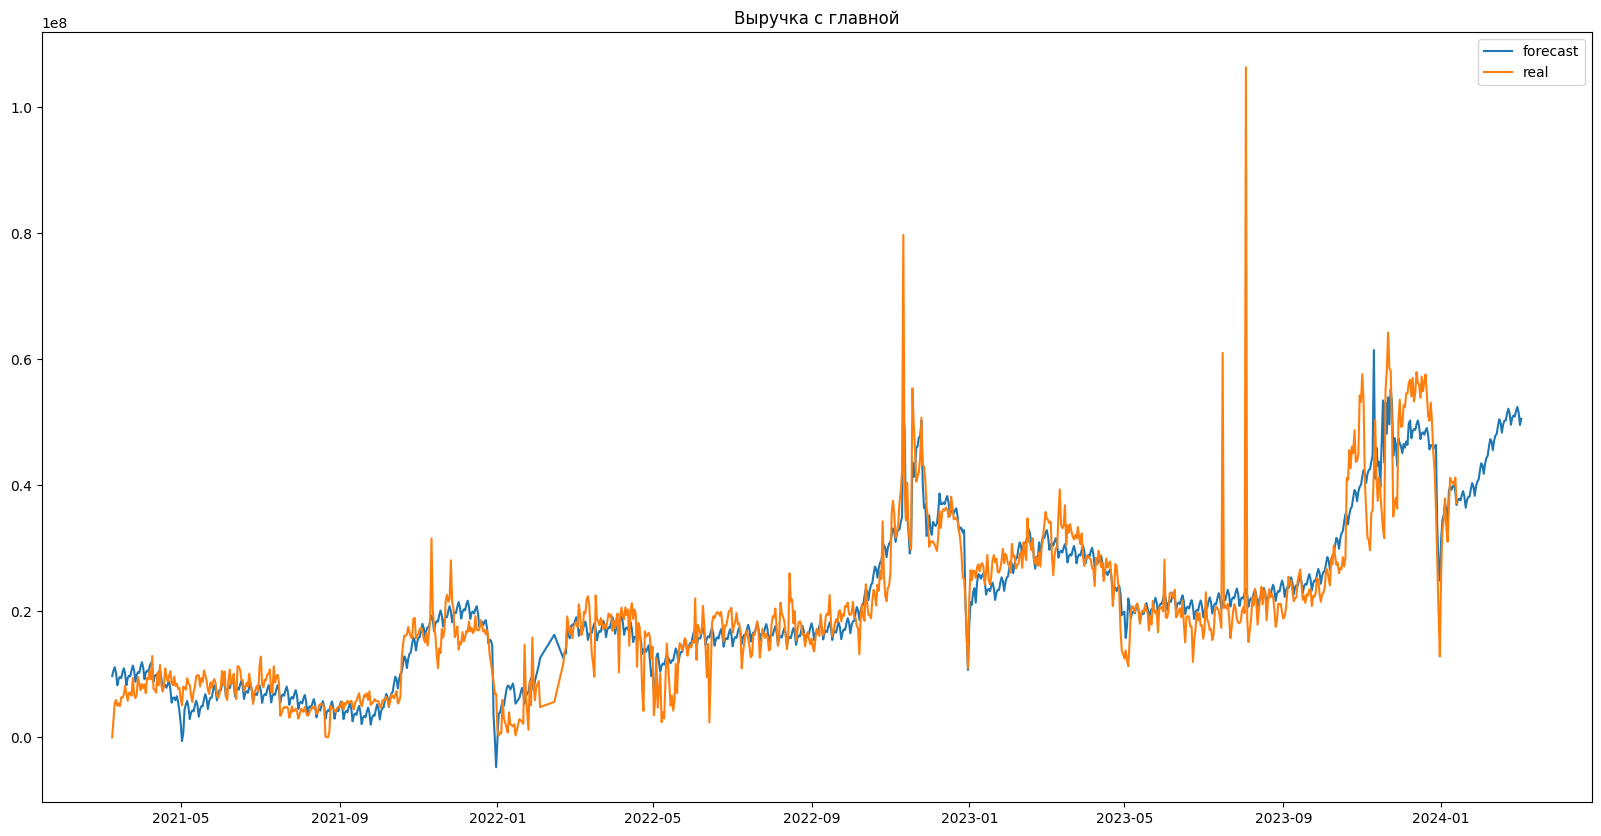

In [60]:
plt.figure()
plt.plot(df.ds, df.yhat, label = "forecast", ls = "-")
plt.plot(df.ds, df.y, label = "real")
plt.title("Выручка с главной")
plt.legend()
plt.show()